In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from config import cache_path, save_path
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

boc = BrainObservatoryCache(manifest_file=str(
            Path(cache_path) / 'brain_observatory_manifest.json'))

eid=501559087
#eid=564425777
eid=567734055

data_dct={}

data_set = boc.get_ophys_experiment_data(eid)

data_dct['movie_stim_table'] = data_set.get_stimulus_table(
                'natural_movie_one')

data_dct['neural_responses'] = data_set.get_dff_traces()[1]

embeddings=np.load(Path(save_path)/Path('natural_movie_one_dino.npy'))
#embeddings=np.load(Path(save_path)/Path('movie_one.npy'))
print(embeddings.shape)
embeddings=np.load('/home/maria/CalciumImaging/movie_one_dino.npy')

def make_regression_data(data_dct, embeddings):
        np.random.seed = 7879
        stimuli = data_dct['movie_stim_table'].loc[data_dct['movie_stim_table']['repeat'] == 9]
        print(stimuli)

        X_train, X_test, y_train_inds, y_test_inds = train_test_split(embeddings,stimuli['start'].values, test_size=0.7, random_state=42)
        y_train=data_dct['neural_responses'][:,y_train_inds]
        y_test=data_dct['neural_responses'][:,y_test_inds]

        return y_train, y_test, X_train, X_test

y_train_movie, y_test_movie, train_embedding,test_embedding = make_regression_data(data_dct, embeddings) 
print(y_train_movie.shape, y_test_movie.shape, train_embedding.shape, test_embedding.shape)

(900, 768)
      frame  start    end  repeat
8100      0  78621  78621       9
8101      1  78622  78622       9
8102      2  78623  78623       9
8103      3  78624  78624       9
8104      4  78625  78625       9
...     ...    ...    ...     ...
8995    895  79521  79521       9
8996    896  79522  79522       9
8997    897  79523  79523       9
8998    898  79524  79524       9
8999    899  79525  79525       9

[900 rows x 4 columns]
(241, 270) (241, 630) (270, 768) (630, 768)


In [3]:

from scipy import sparse
class ReducedRankRegressor(object):
    """
    Reduced Rank Regressor (linear 'bottlenecking' or 'multitask learning')
    - X is an n-by-d matrix of features.
    - Y is an n-by-D matrix of targets.
    - rrank is a rank constraint.
    - reg is a regularization parameter (optional).
    """
    def __init__(self, X, Y, rank, reg=None):
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        if np.size(np.shape(Y)) == 1:
            Y = np.reshape(Y, (-1, 1))
        if reg is None:
            reg = 0
        self.rank = rank

        CXX = np.dot(X.T, X) + reg * sparse.eye(np.size(X, 1))
        CXY = np.dot(X.T, Y)
        _U, _S, V = np.linalg.svd(np.dot(CXY.T, np.dot(np.linalg.pinv(CXX), CXY)))
        self.W = V[0:rank, :].T
        self.A = np.dot(np.linalg.pinv(CXX), np.dot(CXY, self.W)).T

    def __str__(self):
        return 'Reduced Rank Regressor (rank = {})'.format(self.rank)

    def predict(self, X):
        """Predict Y from X."""
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        return np.dot(X, np.dot(self.A.T, self.W.T))

In [16]:
regr=ReducedRankRegressor(train_embedding,y_train_movie.T,50)
predictions=regr.predict(test_embedding)

-0.5721437814728132
-0.6371607705951425
-0.46929363496733645
0.8316980946914051
-0.41785853405059403
-1.0672632397046797
0.7152465972251656
-0.7698370628365592
0.3952261197621846
-1.5006939770971823
-0.4939714308793881
-0.28847743426104366
-0.226707564044911
-0.4983156748835602
-1.1166240784579626
-0.6647808698030728
0.5479405651008531
-0.21133063801306973
-0.39731654120563475
-0.41108860449684337
-0.18200513845331745
-0.5125269020356138
-0.24874547385136525
-0.3079351904094052
-0.4035124837435802
-0.40010402707700155
-0.353343234659268
-0.02023634853586631
0.6051817579237335
-0.40180672313750154
-0.464973861485964
-0.04947354432689366
-0.5070919338871211
-0.6374245564233783
-0.6756898607551349
-1.114180877323112
0.6590487117259167
-0.5407383917567954
-0.5290207743716848
-0.5628588666356527
-0.3391096730051655
-0.4215160230770856
-0.06210907923936282
-1.425343963282046
-0.38266879946145904
-0.44173724103155787
-2.426937379779951
-0.2865376101836925
-0.3064345920883338
-0.82926313833800

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  2.,  0.,  2.,  2.,  1.,  4.,  4.,  3.,  5.,
         5.,  3.,  2.,  2.,  5.,  4., 10.,  7.,  3.,  6., 15., 12.,  9.,
        16., 18., 12., 12.,  8.,  7.,  6.,  0.,  0.,  5.,  2.,  4.,  3.,
         2.,  1.,  1.,  3.,  0.,  0.,  2.,  2.,  2.,  0.,  3.,  1.,  1.,
         1.,  2.,  2.,  3.,  2.,  1.,  1.,  2.,  2.]),
 array([-2.90731749, -2.86920315, -2.83108882, -2.79297448, -2.75486015,
        -2.71674582, -2.67863148, -2.64051715, -2.60240281, -2.56428848,
        -2.52617414, -2.48805981, -2.44994547, -2.41183114, -2.3737168 ,
        -2.33560247, -2.29748813, -2.2593738 , -2.22125947, -2.18314513,
        -2.1450308 , -2.10691646, -2.06880213, -2.03068779, -1.99257346,
        -1.95445912, -1.91634479, -1.87823045, -1.84011612, -1.802001

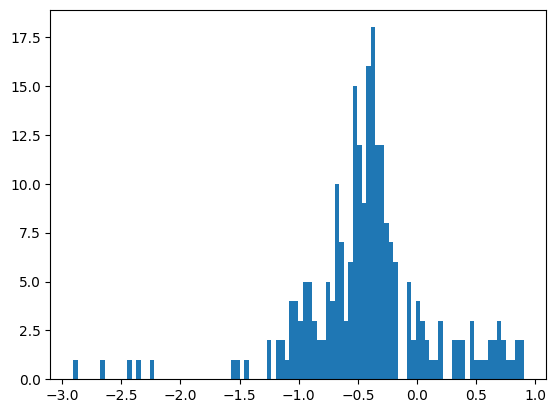

In [17]:
scores=[]
for i in range(0,y_test_movie.shape[0]):
    scores.append(r2_score(y_test_movie.T[:,i], np.asarray(predictions[:,i])))
    print(r2_score(y_test_movie.T[:,i], np.asarray(predictions[:,i])))

import matplotlib.pyplot as plt


plt.hist(scores,bins=100)